In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='6'
import sys

import os
import numpy as np
import pickle
from tensorrtserver.api import *
import cv2
import time
import json

import xlrd
import json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import os
import numpy as np
import sys
import scipy.ndimage as nd
import json
import pickle
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from resnet import *
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import time
import math
from utils import AverageMeter
import cv2
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
from dr_model import DRModel

from train_dr import val, BinClsDataSet, test
from glob import glob

In [2]:
config_file = './config/config_dr_dr.json'
with open(config_file,encoding='gb2312') as f:
    config = json.load(f)
config

{'train_list_file': '/data/zhangwd/data/xray/dr_deformable_1024/total/train_label.txt',
 'val_list_file': '/data/zhangwd/data/xray/dr_deformable_1024/total/val_label.txt',
 'test_list_file': '/data/zhangwd/data/xray/dr_deformable_1024/total/test_label.txt',
 'model_dir': './model',
 'num_classes': 2,
 'scale': 1024,
 'phase': 'train',
 'model': 'resnet34',
 'weight': None,
 'lr': 0.001,
 'mom': 0.9,
 'wd': 0.0001,
 'fix': 50,
 'step': 20,
 'epoch': 120,
 'display': 100,
 'num_workers': 8,
 'batch_size': 8,
 'dim_z': 128,
 'dim_x': 128,
 'optimizer': 'sgd',
 'export_name': 'pos_neg'}

In [3]:
# batch_size = config['batch_size']
# num_workers = config['num_workers']
# lr = config['lr']
# mom = config['mom']
# wd = config['wd']


# model = DRModel('rsn34', config['scale'], config["num_classes"])

# pretrained_weights = config['weight']
# if pretrained_weights is not None:
#     model.load_state_dict(torch.load(pretrained_weights))

# val_file = config["val_list_file"]
# val_ds = BinClsDataSet(val_file)
# val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
#                                     num_workers=num_workers, pin_memory=False)

# model1 = nn.DataParallel(model).cuda()

# criterion = nn.CrossEntropyLoss().cuda()
# optimizer = optim.SGD([{'params': model.parameters()}],
#                                       lr=lr, momentum=mom, weight_decay=wd, nesterov=True)
# _, _, pred_label, gt_label = test(val_dataloader, nn.DataParallel(model).cuda(), criterion, optimizer, 0, 10)



In [4]:
def plot_roc(y_true, y_pred, class_name='dr'):
    print('\n====> plot {} info:\n'.format(class_name))
    log = []
    from sklearn import metrics
    def calc_metrics_table(y_true, y_pred, thresholds):
        metrics_list = list()
        for threshold in thresholds:
            y_pred_binary = np.zeros(y_pred.shape, dtype=np.uint8)
            y_pred_binary[y_pred>threshold] = 1
            tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred_binary).ravel()
            print('tn:{:.3f}\tfp:{:.3f}\tfn:{:.3f}\ttp:{:.3f}\t'.format(tn, fp, fn, tp))
            accuracy = (tp+tn)/(tn+fp+fn+tp)
            sensitivity = tp/(tp+fn)
            specificity = tn/(fp+tn)
            ppv = tp/(tp+fp)
            npv = tn/(tn+fn)
            metrics_list.append([threshold, accuracy, sensitivity, specificity, ppv, npv])
        metrics_table = pd.DataFrame(np.array(metrics_list), columns=['threshold','accuracy','sensitivity','specificity','ppv','npv'])
        return metrics_table


    fpr, tpr, thres = metrics.roc_curve(y_true, y_pred)

    auc = metrics.auc(fpr, tpr)

    thresholds = np.arange(0.05, 1., 0.05)
    metrics_table = calc_metrics_table(y_true, y_pred, thresholds)

    print('\nAUC:%.4f\n'% auc)
    log.append('AUC:%.4f'% auc)

    plt.figure()
    plt.title('{} roc curve'.format(class_name))
    plt.plot(fpr, tpr, 'r')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.xticks(np.arange(0, 1.1, step=0.1))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.grid(ls='--')
    plt.show()

    print(metrics_table)
    log.append(metrics_table)
    return log


In [5]:
# log = plot_roc(np.array(gt_label, dtype=np.float32), np.array(pred_label))

In [6]:
def predict(config_file):
    with open(config_file,encoding='gb2312') as f:
        config = json.load(f)
    
    batch_size = config['batch_size']
    batch_size = 4
    num_workers = config['num_workers']
    lr = config['lr']
    mom = config['mom']
    wd = config['wd']
    class_name = config['export_name']

    model = DRModel('rsn34', config['scale'], config["num_classes"])
    
    time_stamp = config["export_name"]
    model_dir = os.path.join(config["model_dir"], 'dr_cls_{}'.format(time_stamp))
    
    
    from glob import glob
    print(model_dir)
    checkpoints = glob(os.path.join(model_dir, '*.pth'))
    max_index = 0
    raw_ck = None
    ss = []
    for ck in checkpoints:
        basename = os.path.basename(ck)
        ss = basename.split('_')
        s = ss[3]
        if max_index < int(s):
            max_index = int(s)
    ss[3] = '{:04d}'.format(max_index)
    pretrained_weights = os.path.join(model_dir, '_'.join(ss))
    print('pretrained_weights:\t{}'.format(pretrained_weights))
#     pretrained_weights = config['weight']
    if pretrained_weights is not None:
        model.load_state_dict(torch.load(pretrained_weights))

    val_file = config["test_list_file"]
    val_ds = BinClsDataSet(val_file)
    val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                                        num_workers=num_workers, pin_memory=False)

    model1 = nn.DataParallel(model).cuda()

    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD([{'params': model.parameters()}],
                                          lr=lr, momentum=mom, weight_decay=wd, nesterov=True)
    _, _, pred_label, gt_label = test(val_dataloader, nn.DataParallel(model).cuda(), criterion, optimizer, 0, 10000)

    log = plot_roc(np.array(gt_label, dtype=np.float32), np.array(pred_label), class_name)

./model/dr_cls_pos_neg
pretrained_weights:	./model/dr_cls_pos_neg/ct_pos_recognition_0020_best.pth


/home/zhangwd/code/work/xrayproduct/drCls/train/train_dr.py:136: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  tot_prob = np.append(tot_prob, F.softmax(output).cpu().detach().numpy()[:,1])



====> plot pos_neg info:

tn:29.000	fp:114.000	fn:1.000	tp:526.000	
tn:44.000	fp:99.000	fn:2.000	tp:525.000	
tn:50.000	fp:93.000	fn:2.000	tp:525.000	
tn:59.000	fp:84.000	fn:4.000	tp:523.000	
tn:62.000	fp:81.000	fn:4.000	tp:523.000	
tn:71.000	fp:72.000	fn:5.000	tp:522.000	
tn:74.000	fp:69.000	fn:6.000	tp:521.000	
tn:76.000	fp:67.000	fn:6.000	tp:521.000	
tn:80.000	fp:63.000	fn:11.000	tp:516.000	
tn:82.000	fp:61.000	fn:12.000	tp:515.000	
tn:88.000	fp:55.000	fn:14.000	tp:513.000	
tn:94.000	fp:49.000	fn:21.000	tp:506.000	
tn:100.000	fp:43.000	fn:24.000	tp:503.000	
tn:101.000	fp:42.000	fn:27.000	tp:500.000	
tn:105.000	fp:38.000	fn:37.000	tp:490.000	
tn:111.000	fp:32.000	fn:50.000	tp:477.000	
tn:117.000	fp:26.000	fn:66.000	tp:461.000	
tn:125.000	fp:18.000	fn:96.000	tp:431.000	
tn:133.000	fp:10.000	fn:171.000	tp:356.000	

AUC:0.9276



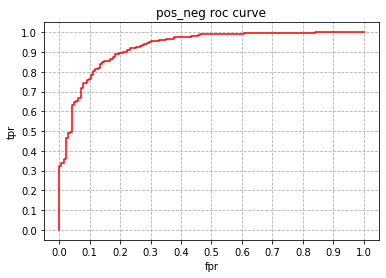

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.828358     0.998102     0.202797  0.821875  0.966667
1        0.10  0.849254     0.996205     0.307692  0.841346  0.956522
2        0.15  0.858209     0.996205     0.349650  0.849515  0.961538
3        0.20  0.868657     0.992410     0.412587  0.861614  0.936508
4        0.25  0.873134     0.992410     0.433566  0.865894  0.939394
5        0.30  0.885075     0.990512     0.496503  0.878788  0.934211
6        0.35  0.888060     0.988615     0.517483  0.883051  0.925000
7        0.40  0.891045     0.988615     0.531469  0.886054  0.926829
8        0.45  0.889552     0.979127     0.559441  0.891192  0.879121
9        0.50  0.891045     0.977230     0.573427  0.894097  0.872340
10       0.55  0.897015     0.973435     0.615385  0.903169  0.862745
11       0.60  0.895522     0.960152     0.657343  0.911712  0.817391
12       0.65  0.900000     0.954459     0.699301  0.921245  0.806452
13       0.70  0.897

/home/zhangwd/code/work/xrayproduct/drCls/train/train_dr.py:136: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  tot_prob = np.append(tot_prob, F.softmax(output).cpu().detach().numpy()[:,1])



====> plot zhudongmai info:

tn:74.000	fp:236.000	fn:0.000	tp:218.000	
tn:107.000	fp:203.000	fn:5.000	tp:213.000	
tn:128.000	fp:182.000	fn:12.000	tp:206.000	
tn:156.000	fp:154.000	fn:14.000	tp:204.000	
tn:176.000	fp:134.000	fn:26.000	tp:192.000	
tn:200.000	fp:110.000	fn:34.000	tp:184.000	
tn:218.000	fp:92.000	fn:51.000	tp:167.000	
tn:236.000	fp:74.000	fn:61.000	tp:157.000	
tn:247.000	fp:63.000	fn:74.000	tp:144.000	
tn:257.000	fp:53.000	fn:91.000	tp:127.000	
tn:272.000	fp:38.000	fn:105.000	tp:113.000	
tn:279.000	fp:31.000	fn:119.000	tp:99.000	
tn:283.000	fp:27.000	fn:139.000	tp:79.000	
tn:293.000	fp:17.000	fn:159.000	tp:59.000	
tn:300.000	fp:10.000	fn:175.000	tp:43.000	
tn:305.000	fp:5.000	fn:200.000	tp:18.000	
tn:309.000	fp:1.000	fn:209.000	tp:9.000	
tn:310.000	fp:0.000	fn:217.000	tp:1.000	
tn:310.000	fp:0.000	fn:217.000	tp:1.000	

AUC:0.8164



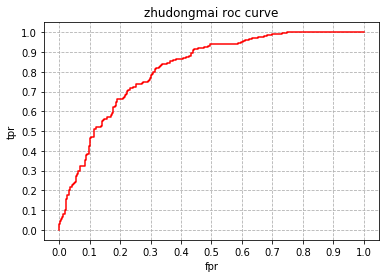

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.553030     1.000000     0.238710  0.480176  1.000000
1        0.10  0.606061     0.977064     0.345161  0.512019  0.955357
2        0.15  0.632576     0.944954     0.412903  0.530928  0.914286
3        0.20  0.681818     0.935780     0.503226  0.569832  0.917647
4        0.25  0.696970     0.880734     0.567742  0.588957  0.871287
5        0.30  0.727273     0.844037     0.645161  0.625850  0.854701
6        0.35  0.729167     0.766055     0.703226  0.644788  0.810409
7        0.40  0.744318     0.720183     0.761290  0.679654  0.794613
8        0.45  0.740530     0.660550     0.796774  0.695652  0.769470
9        0.50  0.727273     0.582569     0.829032  0.705556  0.738506
10       0.55  0.729167     0.518349     0.877419  0.748344  0.721485
11       0.60  0.715909     0.454128     0.900000  0.761538  0.701005
12       0.65  0.685606     0.362385     0.912903  0.745283  0.670616
13       0.70  0.666

/home/zhangwd/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


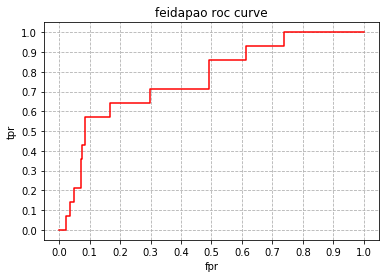

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.690702     0.714286     0.690058  0.059172  0.988827
1        0.10  0.850095     0.571429     0.857700  0.098765  0.986547
2        0.15  0.910816     0.357143     0.925926  0.116279  0.981405
3        0.20  0.933586     0.214286     0.953216  0.111111  0.978000
4        0.25  0.943074     0.142857     0.964912  0.100000  0.976331
5        0.30  0.954459     0.000000     0.980507  0.000000  0.972921
6        0.35  0.960152     0.000000     0.986355  0.000000  0.973077
7        0.40  0.963947     0.000000     0.990253  0.000000  0.973180
8        0.45  0.965844     0.000000     0.992203  0.000000  0.973231
9        0.50  0.965844     0.000000     0.992203  0.000000  0.973231
10       0.55  0.969639     0.000000     0.996101  0.000000  0.973333
11       0.60  0.969639     0.000000     0.996101  0.000000  0.973333
12       0.65  0.973435     0.000000     1.000000       NaN  0.973435
13       0.70  0.973

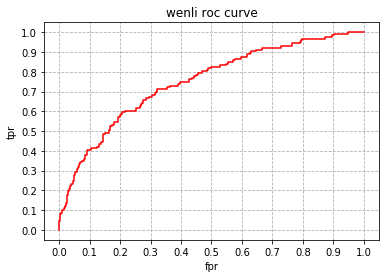

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.353783     0.968254     0.140496  0.281106  0.927273
1        0.10  0.505112     0.896825     0.369146  0.330409  0.911565
2        0.15  0.607362     0.785714     0.545455  0.375000  0.880000
3        0.20  0.683027     0.714286     0.672176  0.430622  0.871429
4        0.25  0.732106     0.603175     0.776860  0.484076  0.849398
5        0.30  0.748466     0.523810     0.826446  0.511628  0.833333
6        0.35  0.754601     0.420635     0.870523  0.530000  0.812339
7        0.40  0.773006     0.380952     0.909091  0.592593  0.808824
8        0.45  0.779141     0.309524     0.942149  0.650000  0.797203
9        0.50  0.773006     0.246032     0.955923  0.659574  0.785068
10       0.55  0.773006     0.198413     0.972452  0.714286  0.777533
11       0.60  0.760736     0.142857     0.975207  0.666667  0.766234
12       0.65  0.756646     0.103175     0.983471  0.684211  0.759574
13       0.70  0.760

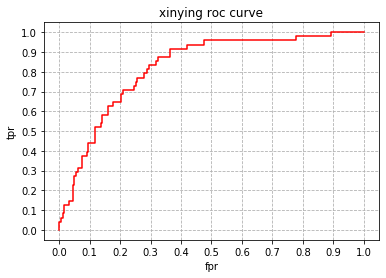

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.886364     0.291667     0.945833  0.350000  0.930328
1        0.10  0.893939     0.125000     0.970833  0.300000  0.917323
2        0.15  0.903409     0.083333     0.985417  0.363636  0.914894
3        0.20  0.905303     0.083333     0.987500  0.400000  0.915058
4        0.25  0.907197     0.062500     0.991667  0.428571  0.913628
5        0.30  0.909091     0.062500     0.993750  0.500000  0.913793
6        0.35  0.909091     0.041667     0.995833  0.500000  0.912214
7        0.40  0.910985     0.041667     0.997917  0.666667  0.912381
8        0.45  0.912879     0.041667     1.000000  1.000000  0.912548
9        0.50  0.910985     0.020833     1.000000  1.000000  0.910816
10       0.55  0.910985     0.020833     1.000000  1.000000  0.910816
11       0.60  0.910985     0.020833     1.000000  1.000000  0.910816
12       0.65  0.910985     0.020833     1.000000  1.000000  0.910816
13       0.70  0.910

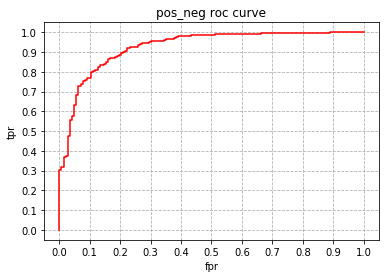

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.823881     0.998102     0.181818  0.818040  0.962963
1        0.10  0.847761     0.996205     0.300699  0.840000  0.955556
2        0.15  0.853731     0.994307     0.335664  0.846527  0.941176
3        0.20  0.865672     0.990512     0.405594  0.859967  0.920635
4        0.25  0.870149     0.988615     0.433566  0.865449  0.911765
5        0.30  0.882090     0.988615     0.489510  0.877104  0.921053
6        0.35  0.886567     0.984820     0.524476  0.884157  0.903614
7        0.40  0.889552     0.984820     0.538462  0.887179  0.905882
8        0.45  0.894030     0.981025     0.573427  0.894464  0.891304
9        0.50  0.895522     0.979127     0.587413  0.897391  0.884211
10       0.55  0.895522     0.971537     0.615385  0.902998  0.854369
11       0.60  0.894030     0.958254     0.657343  0.911552  0.810345
12       0.65  0.897015     0.954459     0.685315  0.917883  0.803279
13       0.70  0.897

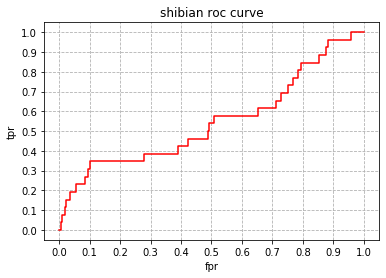

    threshold  accuracy  sensitivity  specificity  ppv       npv
0        0.05  0.950664          0.0          1.0  NaN  0.950664
1        0.10  0.950664          0.0          1.0  NaN  0.950664
2        0.15  0.950664          0.0          1.0  NaN  0.950664
3        0.20  0.950664          0.0          1.0  NaN  0.950664
4        0.25  0.950664          0.0          1.0  NaN  0.950664
5        0.30  0.950664          0.0          1.0  NaN  0.950664
6        0.35  0.950664          0.0          1.0  NaN  0.950664
7        0.40  0.950664          0.0          1.0  NaN  0.950664
8        0.45  0.950664          0.0          1.0  NaN  0.950664
9        0.50  0.950664          0.0          1.0  NaN  0.950664
10       0.55  0.950664          0.0          1.0  NaN  0.950664
11       0.60  0.950664          0.0          1.0  NaN  0.950664
12       0.65  0.950664          0.0          1.0  NaN  0.950664
13       0.70  0.950664          0.0          1.0  NaN  0.950664
14       0.75  0.950664  

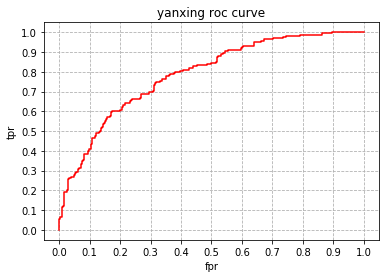

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.648289     0.828571     0.558405  0.483333  0.867257
1        0.10  0.703422     0.697143     0.706553  0.542222  0.823920
2        0.15  0.731939     0.640000     0.777778  0.589474  0.812500
3        0.20  0.747148     0.577143     0.831909  0.631250  0.797814
4        0.25  0.745247     0.502857     0.866097  0.651852  0.777494
5        0.30  0.743346     0.445714     0.891738  0.672414  0.763415
6        0.35  0.731939     0.382857     0.905983  0.670000  0.746479
7        0.40  0.730038     0.331429     0.928775  0.698795  0.735892
8        0.45  0.726236     0.285714     0.945869  0.724638  0.726477
9        0.50  0.731939     0.268571     0.962963  0.783333  0.725322
10       0.55  0.731939     0.251429     0.971510  0.814815  0.722458
11       0.60  0.722433     0.222857     0.971510  0.795918  0.714885
12       0.65  0.720532     0.188571     0.985755  0.868421  0.709016
13       0.70  0.714

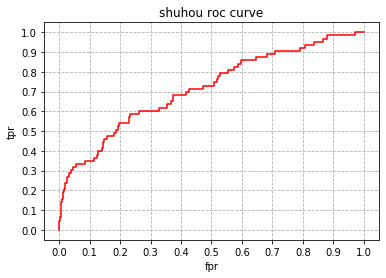

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.361702     0.904762     0.286344  0.149606  0.955882
1        0.10  0.715667     0.603175     0.731278  0.237500  0.929972
2        0.15  0.814313     0.396825     0.872247  0.301205  0.912442
3        0.20  0.868472     0.317460     0.944934  0.444444  0.908898
4        0.25  0.882012     0.285714     0.964758  0.529412  0.906832
5        0.30  0.885880     0.253968     0.973568  0.571429  0.903885
6        0.35  0.889749     0.222222     0.982379  0.636364  0.901010
7        0.40  0.887814     0.174603     0.986784  0.647059  0.896000
8        0.45  0.889749     0.158730     0.991189  0.714286  0.894632
9        0.50  0.889749     0.142857     0.993392  0.750000  0.893069
10       0.55  0.889749     0.142857     0.993392  0.750000  0.893069
11       0.60  0.889749     0.142857     0.993392  0.750000  0.893069
12       0.65  0.889749     0.142857     0.993392  0.750000  0.893069
13       0.70  0.887

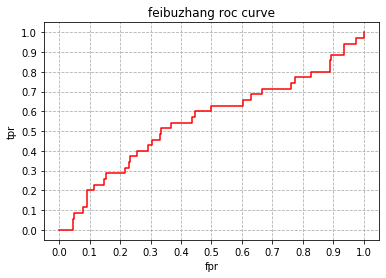

    threshold  accuracy  sensitivity  specificity  ppv       npv
0        0.05  0.929791          0.0     0.995935  0.0  0.933333
1        0.10  0.933586          0.0     1.000000  NaN  0.933586
2        0.15  0.933586          0.0     1.000000  NaN  0.933586
3        0.20  0.933586          0.0     1.000000  NaN  0.933586
4        0.25  0.933586          0.0     1.000000  NaN  0.933586
5        0.30  0.933586          0.0     1.000000  NaN  0.933586
6        0.35  0.933586          0.0     1.000000  NaN  0.933586
7        0.40  0.933586          0.0     1.000000  NaN  0.933586
8        0.45  0.933586          0.0     1.000000  NaN  0.933586
9        0.50  0.933586          0.0     1.000000  NaN  0.933586
10       0.55  0.933586          0.0     1.000000  NaN  0.933586
11       0.60  0.933586          0.0     1.000000  NaN  0.933586
12       0.65  0.933586          0.0     1.000000  NaN  0.933586
13       0.70  0.933586          0.0     1.000000  NaN  0.933586
14       0.75  0.933586  

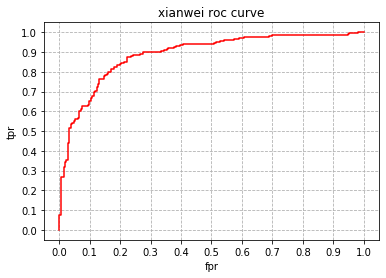

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.700190     0.984127     0.278302  0.669546  0.921875
1        0.10  0.759013     0.955556     0.466981  0.727053  0.876106
2        0.15  0.785579     0.942857     0.551887  0.757653  0.866667
3        0.20  0.804554     0.926984     0.622642  0.784946  0.851613
4        0.25  0.806452     0.907937     0.655660  0.796657  0.827381
5        0.30  0.821632     0.898413     0.707547  0.820290  0.824176
6        0.35  0.827324     0.882540     0.745283  0.837349  0.810256
7        0.40  0.831120     0.876190     0.764151  0.846626  0.805970
8        0.45  0.825427     0.850794     0.787736  0.856230  0.780374
9        0.50  0.825427     0.834921     0.811321  0.867987  0.767857
10       0.55  0.817837     0.809524     0.830189  0.876289  0.745763
11       0.60  0.810247     0.790476     0.839623  0.879859  0.729508
12       0.65  0.800759     0.755556     0.867925  0.894737  0.704981
13       0.70  0.772

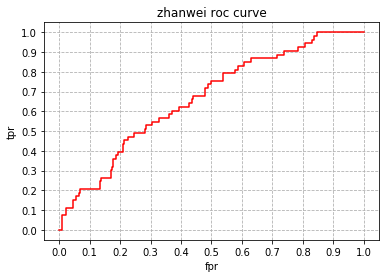

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.335227     0.886792     0.273684  0.119898  0.955882
1        0.10  0.596591     0.622642     0.593684  0.146018  0.933775
2        0.15  0.736742     0.471698     0.766316  0.183824  0.928571
3        0.20  0.801136     0.207547     0.867368  0.148649  0.907489
4        0.25  0.856061     0.188679     0.930526  0.232558  0.911340
5        0.30  0.875000     0.113208     0.960000  0.240000  0.906561
6        0.35  0.888258     0.094340     0.976842  0.312500  0.906250
7        0.40  0.897727     0.075472     0.989474  0.444444  0.905588
8        0.45  0.893939     0.000000     0.993684  0.000000  0.899048
9        0.50  0.897727     0.000000     0.997895  0.000000  0.899431
10       0.55  0.897727     0.000000     0.997895  0.000000  0.899431
11       0.60  0.897727     0.000000     0.997895  0.000000  0.899431
12       0.65  0.897727     0.000000     0.997895  0.000000  0.899431
13       0.70  0.897

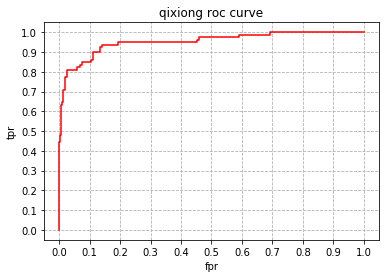

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.886148     0.898734     0.883929  0.577236  0.980198
1        0.10  0.905123     0.848101     0.915179  0.638095  0.971564
2        0.15  0.912713     0.835443     0.926339  0.666667  0.969626
3        0.20  0.922201     0.822785     0.939732  0.706522  0.967816
4        0.25  0.931689     0.810127     0.953125  0.752941  0.966063
5        0.30  0.937381     0.810127     0.959821  0.780488  0.966292
6        0.35  0.944972     0.810127     0.968750  0.820513  0.966592
7        0.40  0.946869     0.810127     0.970982  0.831169  0.966667
8        0.45  0.948767     0.810127     0.973214  0.842105  0.966741
9        0.50  0.946869     0.797468     0.973214  0.840000  0.964602
10       0.55  0.948767     0.772152     0.979911  0.871429  0.960613
11       0.60  0.944972     0.734177     0.982143  0.878788  0.954447
12       0.65  0.944972     0.734177     0.982143  0.878788  0.954447
13       0.70  0.941

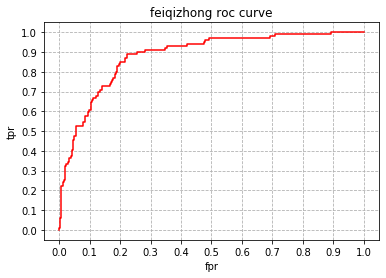

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.700190     0.919192     0.649533  0.377593  0.972028
1        0.10  0.796964     0.868687     0.780374  0.477778  0.962536
2        0.15  0.814042     0.727273     0.834112  0.503497  0.929688
3        0.20  0.848197     0.656566     0.892523  0.585586  0.918269
4        0.25  0.848197     0.575758     0.911215  0.600000  0.902778
5        0.30  0.851992     0.525253     0.927570  0.626506  0.894144
6        0.35  0.859583     0.474747     0.948598  0.681159  0.886463
7        0.40  0.851992     0.404040     0.955607  0.677966  0.873932
8        0.45  0.848197     0.363636     0.960280  0.679245  0.867089
9        0.50  0.853890     0.343434     0.971963  0.739130  0.864865
10       0.55  0.850095     0.282828     0.981308  0.777778  0.855397
11       0.60  0.844402     0.242424     0.983645  0.774194  0.848790
12       0.65  0.848197     0.222222     0.992991  0.880000  0.846614
13       0.70  0.831

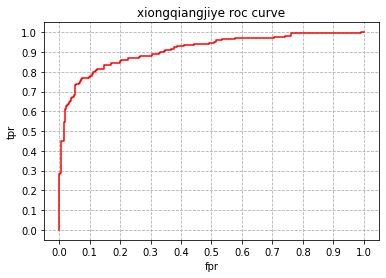

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.785579     0.869822     0.745810  0.617647  0.923875
1        0.10  0.815939     0.857988     0.796089  0.665138  0.922330
2        0.15  0.831120     0.834320     0.829609  0.698020  0.913846
3        0.20  0.846300     0.816568     0.860335  0.734043  0.908555
4        0.25  0.857685     0.804734     0.882682  0.764045  0.905444
5        0.30  0.855787     0.786982     0.888268  0.768786  0.898305
6        0.35  0.861480     0.781065     0.899441  0.785714  0.896936
7        0.40  0.859583     0.769231     0.902235  0.787879  0.892265
8        0.45  0.870968     0.769231     0.918994  0.817610  0.894022
9        0.50  0.874763     0.757396     0.930168  0.836601  0.890374
10       0.55  0.874763     0.745562     0.935754  0.845638  0.886243
11       0.60  0.876660     0.739645     0.941341  0.856164  0.884514
12       0.65  0.869070     0.704142     0.946927  0.862319  0.871465
13       0.70  0.865

In [7]:
config_files = glob('./config/*.json')
for config_file in config_files:
    predict(config_file)
    print('\n\n\n\n\n')

In [8]:
# from glob import glob
# model_path = './model/dr_cls_feiqizhong/'
# checkpoints = glob(os.path.join(model_path, '*.pth'))
# max_index = 0
# raw_ck = None
# for ck in checkpoints:
#     basename = os.path.basename(ck)
#     ss = basename.split('_')
#     s = ss[3]
#     if max_index < int(s):
#         max_index = int(s)
# print(ss)
# print(max_index)
# ss[3] = '{:04d}'.format(max_index)
# print(ss)

In [23]:
def stat_ratio(infile):
    positive_cnt = 0
    negative_cnt = 0
    with open(infile) as f:
        for line in f.readlines():
            line = line.strip()
            if line is None or len(line) == 0:
                continue
            ss = line.split('\t')
            if len(ss) != 2:
                continue
            if int(ss[1]) == 0:
                negative_cnt += 1
            else:
                positive_cnt += 1
    return positive_cnt, negative_cnt

def stat_ds(config_file):
    with open(config_file,encoding='gb2312') as f:
        config = json.load(f)
    train_file = config["train_list_file"]
    val_file = config["val_list_file"]
    test_file = config["test_list_file"]
    train_p, train_n = stat_ratio(train_file)
    val_p, val_n = stat_ratio(val_file)
    test_p, test_n = stat_ratio(test_file)
    total_p = train_p + val_p + test_p
    total_n = train_n + val_n + test_n
    print('====> {}:'.format(config["export_name"]))
    print('\t====> train set:\n\t\tpos:{}  neg:{}'.format(train_p, train_n))
    print('\t====> val set:\n\t\tpos:{}  neg:{}'.format(val_p, val_n))
    print('\t====> test set:\n\t\tpos:{}  neg:{}'.format(test_p, test_n))
    print('\t====> total set:\n\t\tpos:{}  neg:{}'.format(total_p, total_n))

In [24]:
config_files = glob('./config/*.json')
for config_file in config_files:
    stat_ds(config_file)
    print('\n\n\n\n\n')

====> pos_neg:
	====> train set:
		pos:5335  neg:1714
	====> val set:
		pos:1579  neg:395
	====> test set:
		pos:527  neg:143
	====> total set:
		pos:7441  neg:2252






====> zhudongmai:
	====> train set:
		pos:2315  neg:3711
	====> val set:
		pos:592  neg:927
	====> test set:
		pos:218  neg:310
	====> total set:
		pos:3125  neg:4948






====> feidapao:
	====> train set:
		pos:168  neg:5019
	====> val set:
		pos:42  neg:1427
	====> test set:
		pos:14  neg:513
	====> total set:
		pos:224  neg:6959






====> wenli:
	====> train set:
		pos:1511  neg:4376
	====> val set:
		pos:378  neg:1186
	====> test set:
		pos:126  neg:363
	====> total set:
		pos:2015  neg:5925






====> xinying:
	====> train set:
		pos:566  neg:5387
	====> val set:
		pos:137  neg:1362
	====> test set:
		pos:48  neg:480
	====> total set:
		pos:751  neg:7229






====> pos_neg:
	====> train set:
		pos:5335  neg:1714
	====> val set:
		pos:1579  neg:395
	====> test set:
		pos:527  neg:143
	====> total set:
		pos:7